In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.stats import pearsonr, ttest_rel
from adjustText import adjust_text
import seaborn as sns
import sys
import os

sys.path.append('../../../Code/')
from utils import read_dataset_log, TCAT


## Prepare query

In [2]:
outdir = '../../../Data/PerDataset/Stimseq/'
figdir = '../../../Figures/Components/'

In [3]:
dataset_info = read_dataset_log()
dataset_info.index = dataset_info['dataset']
counts_fn = dataset_info.loc['Stimseq', 'raw_counts_fn']

In [4]:
query_adata = sc.read(counts_fn)
#query_adata = sc.AnnData(X=query_adata.raw.X, var=query_adata.raw.var, obs=query_adata.obs, obsm=query_adata.obsm)
#query_adata.var.index = query_adata.var['gene_name']
query_adata

Only considering the two last: ['.doubletfilt', '.h5ad'].
Only considering the two last: ['.doubletfilt', '.h5ad'].


AnnData object with n_obs × n_vars = 43222 × 36738
    obs: 'barcode', 'BRI', 'Run', 'Well', 'Batch', 'Biobank_ID', 'Sort_Status', 'HTO_Status', 'Demuxlet_Assignment', 'Total_RNA_Count', 'Total_ADT_Count', 'Total_HTO_Count', 'frac_ADT', 'A_cdr3', 'B_cdr3', 'DEMUX_RD.UNIQ', 'DEMUX_N.SNP', 'DEMUX_BEST', 'DEMUX_SNG.1ST', 'DEMUX_SNG.LLK1', 'DEMUX_DBL.1ST', 'DEMUX_DBL.2ND', 'DEMUX_LLK12', 'DEMUX_PRB.DBL', 'DEMUX_PRB.SNG1', 'batch_name', 'B_is_cell', 'B_high_confidence', 'B_full_length', 'B_productive', 'B_length', 'B_v_gene', 'B_d_gene', 'B_j_gene', 'B_c_gene', 'B_cdr1', 'B_cdr2', 'B_cdr3_nt', 'B_reads', 'B_umis', 'B_raw_clonotype_id', 'B_raw_consensus_id', 'B_Num_Hits_In_Barcode', 'B_Next_Highest_ReadCount', 'B_Num_Productive_In_Barcode', 'B_Has_Unproductive', 'A_is_cell', 'A_high_confidence', 'A_full_length', 'A_productive', 'A_length', 'A_v_gene', 'A_d_gene', 'A_j_gene', 'A_c_gene', 'A_cdr1', 'A_cdr2', 'A_cdr3_nt', 'A_reads', 'A_umis', 'A_raw_clonotype_id', 'A_raw_consensus_id', 'A_Num_H

In [5]:
vc = query_adata.var['gene_name'].value_counts()
tofilt = list(vc.index[vc>1])
tofilt

['TMSB15B',
 'GOLGA8M',
 'LINC01505',
 'ARMCX5-GPRASP2',
 'CYB561D2',
 'TBCE',
 'MATR3',
 'LINC01238',
 'GGT1',
 'HSPA14']

In [6]:
query_adata = query_adata[:,~query_adata.var['gene_name'].isin(tofilt)]
query_adata.var.index = query_adata.var['gene_name']

In [7]:
sc.pp.filter_genes(query_adata, min_cells=10)

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
query_adata = query_adata[:,query_adata.var['feature_type']!='Antibody Capture']

In [9]:
metagepinfo = read_dataset_log('Current Meta-program Paths').loc[0,:]
metagepinfo

clustering_fn                      /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn      /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                        /data/srlab1/TCAT/Data/TCAT/MergedHVG.UnionAll...
tpm_norm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_norm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                     /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
Name: 0, dtype: object

In [10]:
tcat_dir = '/data/srlab1/TCAT/Data/TCAT'
ref_fn = metagepinfo['tpm_norm_spectra']
hvg_fn = metagepinfo['merged_hvgs']

ref = pd.read_csv(ref_fn, sep='\t', index_col=0)
hvgs = pd.read_csv(hvg_fn, sep='\t', header=None)[0]
ref = ref[hvgs]

In [11]:
tmod = TCAT(tpm_norm=True, copy=True)
rf_usage = tmod.fit_transform(query_adata, ref_spectra=ref)
rf_usage_norm = rf_usage.div(rf_usage.sum(axis=1), axis=0)

3235 out of 3393 genes in the reference overlap with the query


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [12]:
tcatfn = os.path.join(outdir, 'TCAT.20231005.tsv')
tcatfn

'../../../Data/PerDataset/Stimseq/TCAT.20231005.tsv'

In [13]:
rf_usage.to_csv(tcatfn, sep='\t')

In [14]:
rf_usage_norm_annot = pd.merge(left=rf_usage_norm, right=query_adata.obs[['Biobank_ID', 'Sort_Status']],
         left_index=True, right_index=True, how='left')

In [15]:
labelfn = '../../../Data/PerDataset/Stimseq/ManualGating.Magic.FinalLabel.20230831.tsv'
gating_label = pd.read_csv(labelfn, sep='\t', index_col=0)['0']
gating_label.head()

3_AAACCTGAGACCGGAT       CD4_CM
3_AAACCTGAGAGGGCTT    CD4_Naive
3_AAACCTGAGAGTCTGG       CD4_EM
3_AAACCTGAGCTAGCCC       CD4_CM
3_AAACCTGAGCTGCCCA       CD4_CM
Name: 0, dtype: object

In [16]:
rf_usage_norm_annot['lineage'] = gating_label.loc[rf_usage_norm_annot.index]

In [21]:
from scipy.stats import ttest_rel

def ttest_paired_allcols(X, Y):
    '''
    Takes 2 pandas.DataFrames X and Y with the same number of rows and columns.
    Performs a paired t-test for each column of X and Y. 
    
    Returns
    ---------------------------------
    Ts - pandas.Series of T statistics
    Ps - pandas.Series of P-values
    '''
    
    Ts = []
    Ps = []
    for g in X.columns:
        T, P = ttest_rel(X[g], Y[g])
        Ts.append(T)
        Ps.append(P)

    Ts = pd.Series(Ts, index=X.columns)
    Ps = pd.Series(Ps, index=X.columns)
    return(Ts, Ps)


def permute_within_group(df, group_col, vartopermute):
    permuted = df.groupby(group_col, group_keys=True).apply(lambda x: x.assign(permuted=np.random.permutation(x[vartopermute]))).reset_index(drop=True)
    return(permuted)

In [22]:
average_usage = rf_usage_norm_annot.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('-', axis=0, level=1)
average_usage_un = average_usage.xs('U', axis=0, level=1)

/tmp/ipykernel_54218/69330195.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = rf_usage_norm_annot.groupby(['Biobank_ID', 'Sort_Status']).mean()


In [23]:
Ts, Ps = ttest_paired_allcols(average_usage_pos, average_usage_neg)

In [24]:
Ts.sort_values(ascending=False)

CD4_CM-2_PTPN13/TNFRSF4_Th17                                      14.149229
HeatShock                                                         10.350342
CellCycle-Sphase_CellCycle_S_DTL/FAM111B                           9.770717
Pan-Cancer:Treg/TNFRSF18_Single                                    9.592866
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5                          9.378133
Cytoskeleton                                                       9.127095
Metallothionein                                                    8.435939
AB_CD278/LGMN/IL21_LAG3/CD38                                       7.056598
EBI3                                                               6.733025
CellCycle-G2M_CellCycle_G2M                                        5.542793
IEG_IEG2                                                           5.380192
CytokineHigh_IL17A/IFNG_TNF/IFNG                                   4.861350
Pan-Cancer:Tex_Single                                              4.529959
Pan-Tissue:N

In [28]:
nperms=1000
permuteP = pd.Series(0, Ps.index)
totest = rf_usage_norm_annot.loc[rf_usage_norm_annot['Sort_Status']!='U',:]
totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('-', axis=0, level=1)
Ts, Ps = ttest_paired_allcols(average_usage_pos, average_usage_neg)
Ts_abs = Ts.abs()

for i in range(nperms):
    if i % 50 == 0:
        print('%d out of %d' % (i+1, nperms))
    permuted = permute_within_group(totest, 'Biobank_ID', 'Sort_Status')
    permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
    Trand,Prand = ttest_paired_allcols(permuted_average_usage.xs('+', axis=0, level=1),
               permuted_average_usage.xs('-', axis=0, level=1))
    permuteP += (Trand.abs()>=Ts_abs).astype(int)

/tmp/ipykernel_54218/1195376544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_54218/1195376544.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the fu

1 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

51 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

101 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

151 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

201 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

251 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

301 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

351 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

401 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

451 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

501 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

551 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

601 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

651 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

701 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

751 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

801 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

851 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

901 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

951 out of 1000


/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_average_usage = permuted.groupby(['Biobank_ID', 'permuted']).mean()
/tmp/ipykernel_54218/1195376544.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  permuted_ave

In [26]:
permuteP /= nperms

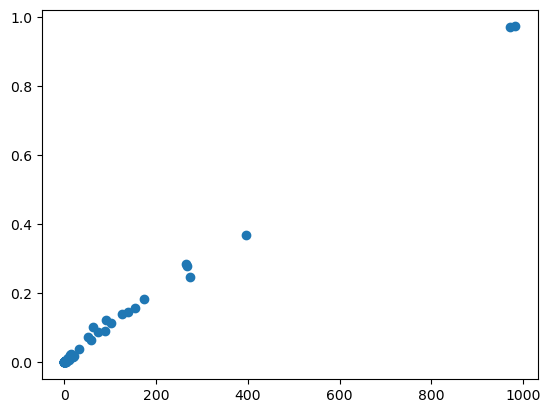

In [29]:
plt.scatter(permuteP, Ps)

Text(0.5, 1.0, 'GEP association with stimulation')

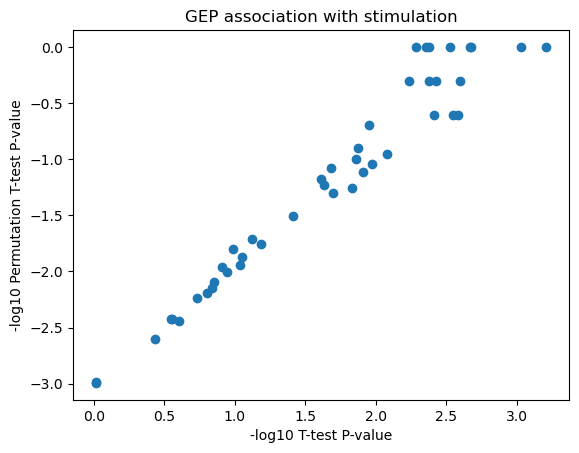

In [30]:
plt.scatter( -1*Ps.apply(np.log10), -1*permuteP.apply(np.log10),)
plt.xlabel('-log10 T-test P-value')
plt.ylabel('-log10 Permutation T-test P-value')
plt.title('GEP association with stimulation')

In [31]:
gepnameinfo = read_dataset_log('GEP_Name')
name_dict = dict(zip(gepnameinfo['MetaGep_Name'], gepnameinfo['Short_Name']))


/tmp/ipykernel_54218/3381047809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_54218/3381047809.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


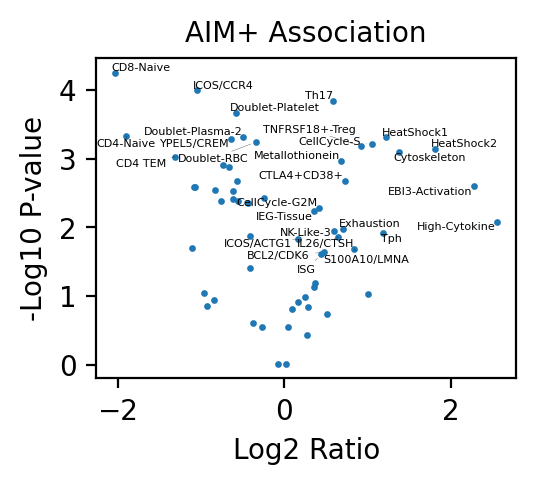

In [48]:
totest = rf_usage_norm_annot.loc[rf_usage_norm_annot['Sort_Status']!='U',:]
totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('-', axis=0, level=1)
Ts, Ps = ttest_paired_allcols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
mean_pos = average_usage_pos.mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200, gridspec_kw={'left':0.2, 'bottom':0.1, 'top':0.9})

summary = pd.concat([Ps, Ts, lograt, mean_pos], axis=1)
summary.columns = ['P', 'T', 'lograt', 'MeanPos']
summary['logP'] = summary['P'].apply(np.log10)*-1
summary = summary.sort_values(by='T', ascending=False)
summary['renamed'] = [name_dict[x] for x in summary.index]

ind = (summary['T']>0) & (summary['P']<.05)
#ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
#ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')
ax.scatter(summary.loc[:, 'lograt'], summary.loc[:, 'logP'], s=2)
ax.set_ylabel('-Log10 P-value', fontsize=10)
ax.set_xlabel('Log2 Ratio', fontsize=10)
ax.set_title('AIM+ Association', fontsize=10)

texts = []
pthresh = .001
for i in summary.index:
    if (summary.at[i, 'P']< pthresh) or ((summary.at[i, 'T']>0) and (summary.at[i, 'P']<.05) ) :
         texts.append(ax.text(summary.at[i, 'lograt'],
                               summary.at[i, 'logP'], name_dict[i],
                               ha='center', va='center', fontsize=4))
        


adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.1))

/tmp/ipykernel_54218/1209979632.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
/tmp/ipykernel_54218/1209979632.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([name_dict[x] for x in toplot], rotation=90, fontsize=8)


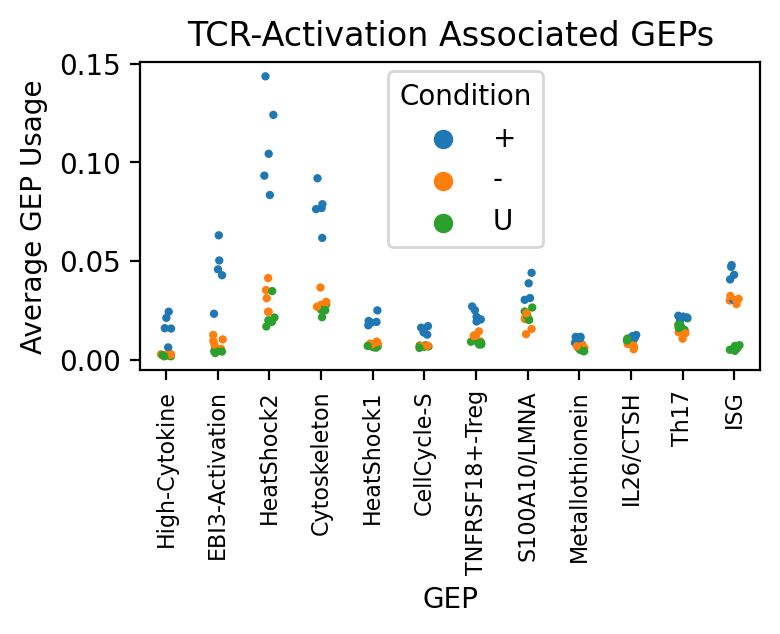

In [49]:
ind = (summary['P']<.05) & (summary['T']>0) & (summary['MeanPos']>0.01) & (summary['lograt']>np.log2(1.5))
toplot = list(summary.loc[ind, :].sort_values(by='lograt', ascending=False).index) + ['ISG']

rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
rf_usage_norm_annot_flat = rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['level_0'].isin(toplot),:]

#(fig,ax) = plt.subplots(1,1, figsize=(5,4), dpi=200, gridspec_kw={'bottom':.55})
(fig,ax) = plt.subplots(1,1, figsize=(4,2), dpi=200)

sns.stripplot(x='level_0', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat, order=toplot, s=3)
ax.set_xticklabels([name_dict[x] for x in toplot], rotation=90, fontsize=8)
ax.legend(loc=(.4,.4), title='Condition')
ax.set_xlabel('GEP', fontsize=10)
ax.set_ylabel('Average GEP Usage', fontsize=10)
ax.set_title('TCR-Activation Associated GEPs', fontsize=12)
plt.savefig(os.path.join(figdir, 'Stimseq.TCRassociatedGEPs.top15.stripplot.png'))
plt.savefig(os.path.join(figdir, 'Stimseq.TCRassociatedGEPs.top15.stripplot.pdf'))

In [54]:
ind = (summary['P']<.01) &(summary['T']>0)
list(summary.loc[ind, 'renamed'])

['Th17',
 'HeatShock1',
 'CellCycle-S',
 'TNFRSF18+-Treg',
 'HeatShock2',
 'Cytoskeleton',
 'Metallothionein',
 'CTLA4+CD38+',
 'EBI3-Activation',
 'CellCycle-G2M',
 'IEG-Tissue',
 'High-Cytokine']

/tmp/ipykernel_54218/311072608.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).agg(lambda x: 100*(x>.05).mean()).unstack().unstack().reset_index()
/tmp/ipykernel_54218/311072608.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([name_dict[x] for x in toplot], rotation=90)


Text(0.5, 1.0, 'TCR-Activation Associated GEPs')

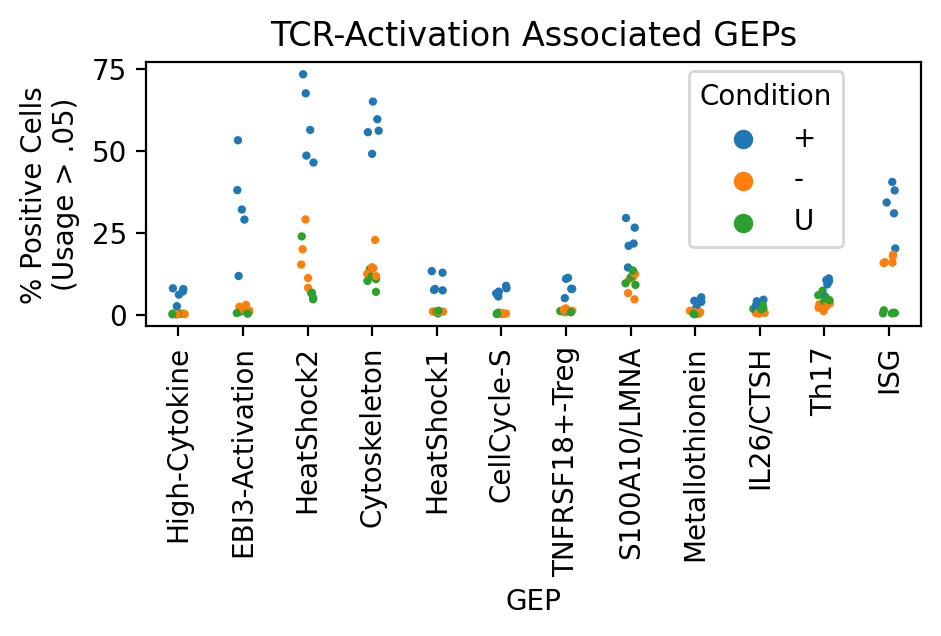

In [36]:
ind = (summary['P']<.05) & (summary['T']>0) & (summary['MeanPos']>0.01) & (summary['lograt']>np.log2(1.5))
toplot = list(summary.loc[ind, :].sort_values(by='lograt', ascending=False).index) + ['ISG']

rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).agg(lambda x: 100*(x>.05).mean()).unstack().unstack().reset_index()
rf_usage_norm_annot_flat = rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['level_0'].isin(toplot),:]

(fig,ax) = plt.subplots(1,1, figsize=(5,4), dpi=200, gridspec_kw={'bottom':.55})
sns.stripplot(x='level_0', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat, order=toplot, s=3)
ax.set_xticklabels([name_dict[x] for x in toplot], rotation=90)
ax.legend(loc=(.7,.3), title='Condition')
ax.set_xlabel('GEP', fontsize=10)
ax.set_ylabel('% Positive Cells\n(Usage > .05)', fontsize=10)
ax.set_title('TCR-Activation Associated GEPs', fontsize=12)
#plt.savefig(os.path.join(figdir, 'Stimseq.TCRassociatedGEPs.top15.stripplot.png'))
#plt.savefig(os.path.join(figdir, 'Stimseq.TCRassociatedGEPs.top15.stripplot.pdf'))

/tmp/ipykernel_54218/667793380.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).agg(lambda x: 100*(x>.1).mean()).unstack().unstack().reset_index()
/tmp/ipykernel_54218/667793380.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([name_dict[x] for x in toplot], rotation=90)


Text(0.5, 1.0, 'TCR-Activation Associated GEPs')

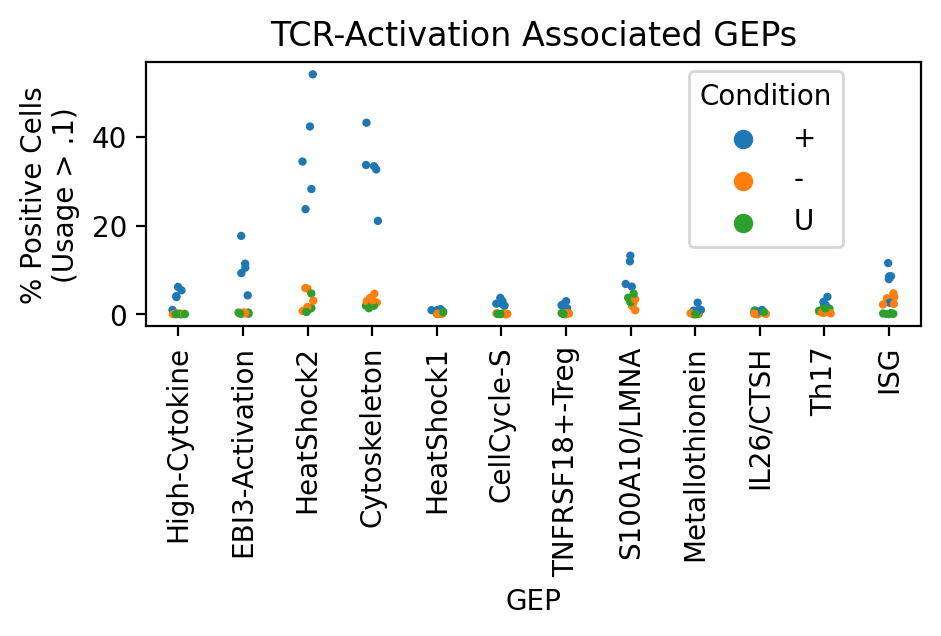

In [37]:
ind = (summary['P']<.05) & (summary['T']>0) & (summary['MeanPos']>0.01) & (summary['lograt']>np.log2(1.5))
toplot = list(summary.loc[ind, :].sort_values(by='lograt', ascending=False).index) + ['ISG']

rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).agg(lambda x: 100*(x>.1).mean()).unstack().unstack().reset_index()
rf_usage_norm_annot_flat = rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['level_0'].isin(toplot),:]

(fig,ax) = plt.subplots(1,1, figsize=(5,4), dpi=200, gridspec_kw={'bottom':.55})
sns.stripplot(x='level_0', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat, order=toplot, s=3)
ax.set_xticklabels([name_dict[x] for x in toplot], rotation=90)
ax.legend(loc=(.7,.3), title='Condition')
ax.set_xlabel('GEP', fontsize=10)
ax.set_ylabel('% Positive Cells\n(Usage > .1)', fontsize=10)
ax.set_title('TCR-Activation Associated GEPs', fontsize=12)
#plt.savefig(os.path.join(figdir, 'Stimseq.TCRassociatedGEPs.top15.stripplot.png'))
#plt.savefig(os.path.join(figdir, 'Stimseq.TCRassociatedGEPs.top15.stripplot.pdf'))

/tmp/ipykernel_54218/1444518009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_54218/1444518009.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


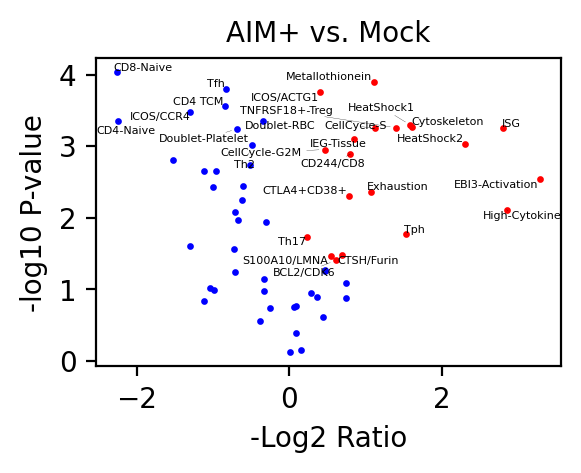

In [39]:
totest = rf_usage_norm_annot.loc[rf_usage_norm_annot['Sort_Status']!='-',:]
totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('U', axis=0, level=1)
Ts, Ps = ttest_paired_allcols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)

summary = pd.concat([Ps, Ts, lograt], axis=1)
summary.columns = ['P', 'T', 'lograt']
summary['logP'] = summary['P'].apply(np.log10)*-1
summary = summary.sort_values(by='T', ascending=False)
summary['renamed'] = [name_dict[x] for x in summary.index]

ind = (summary['T']>0) & (summary['P']<.05)
ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')
ax.set_ylabel('-log10 P-value', fontsize=10)
ax.set_xlabel('-Log2 Ratio', fontsize=10)
ax.set_title('AIM+ vs. Mock', fontsize=10)

texts = []
pthresh = .001
for i in summary.index:
    if (summary.at[i, 'P']< pthresh) or ((summary.at[i, 'T']>0) and (summary.at[i, 'P']<.05) ) :
         texts.append(ax.text(summary.at[i, 'lograt'],
                               summary.at[i, 'logP'], name_dict[i],
                               ha='center', va='center', fontsize=4))
        


adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.1))

In [75]:
summary.head(15)['renamed'].values

array(['Th17', 'HeatShock1', 'CellCycle-S', 'TNFRSF18+-Treg',
       'HeatShock2', 'Cytoskeleton', 'Metallothionein', 'CTLA4+CD38+',
       'EBI3-Activation', 'CellCycle-G2M', 'IEG-Tissue', 'High-Cytokine',
       'Exhaustion', 'NK-Like-3', 'Tph'], dtype=object)

/tmp/ipykernel_53349/2994338576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_53349/2994338576.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


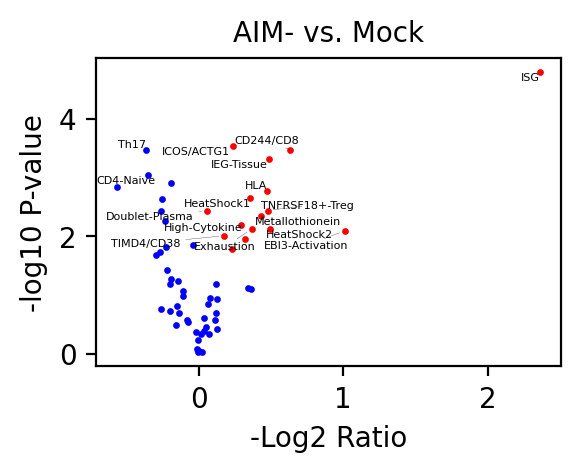

In [54]:
totest = rf_usage_norm_annot.loc[rf_usage_norm_annot['Sort_Status']!='+',:]
totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('-', axis=0, level=1)
average_usage_neg = average_usage.xs('U', axis=0, level=1)
Ts, Ps = ttest_all_cols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)

summary = pd.concat([Ps, Ts, lograt], axis=1)
summary.columns = ['P', 'T', 'lograt']
summary['logP'] = summary['P'].apply(np.log10)*-1
summary = summary.sort_values(by='T', ascending=False)
summary['renamed'] = [name_dict[x] for x in summary.index]

ind = (summary['T']>0) & (summary['P']<.05)
ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')
ax.set_ylabel('-log10 P-value', fontsize=10)
ax.set_xlabel('-Log2 Ratio', fontsize=10)
ax.set_title('AIM- vs. Mock', fontsize=10)

texts = []
pthresh = .001
for i in summary.index:
    if (summary.at[i, 'P']< pthresh) or ((summary.at[i, 'T']>0) and (summary.at[i, 'P']<.01) ) :
         texts.append(ax.text(summary.at[i, 'lograt'],
                               summary.at[i, 'logP'], name_dict[i],
                               ha='center', va='center', fontsize=4))
        


adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.1))

## Repeat after subsetting on CD4 memory

/tmp/ipykernel_53349/3780681386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_53349/3780681386.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


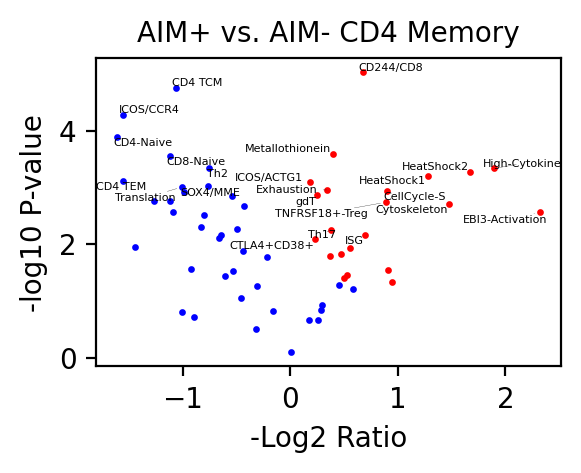

In [191]:
ind = (rf_usage_norm_annot['Sort_Status']!='U') & rf_usage_norm_annot['lineage'].isin(['CD4_CM', 'CD4_EM', 'CD4_TEMRA'])
totest = rf_usage_norm_annot.loc[ind,:]
totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('-', axis=0, level=1)
Ts, Ps = ttest_all_cols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)

summary = pd.concat([Ps, Ts, lograt], axis=1)
summary.columns = ['P', 'T', 'lograt']
summary['logP'] = summary['P'].apply(np.log10)*-1
summary = summary.sort_values(by='T', ascending=False)
summary['renamed'] = [name_dict[x] for x in summary.index]

ind = (summary['T']>0) & (summary['P']<.05)
ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')
ax.set_ylabel('-log10 P-value', fontsize=10)
ax.set_xlabel('-Log2 Ratio', fontsize=10)
ax.set_title('AIM+ vs. AIM- CD4 Memory', fontsize=10)

texts = []
pthresh = .001
for i in summary.index:
    if (summary.at[i, 'P']< pthresh) or ((summary.at[i, 'T']>0) and (summary.at[i, 'P']<.01) ) :
         texts.append(ax.text(summary.at[i, 'lograt'],
                               summary.at[i, 'logP'], name_dict[i],
                               ha='center', va='center', fontsize=4))
        


adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.1))

/tmp/ipykernel_53349/1119556912.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
/tmp/ipykernel_53349/1119556912.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([name_dict[x] for x in toplot], rotation=90)


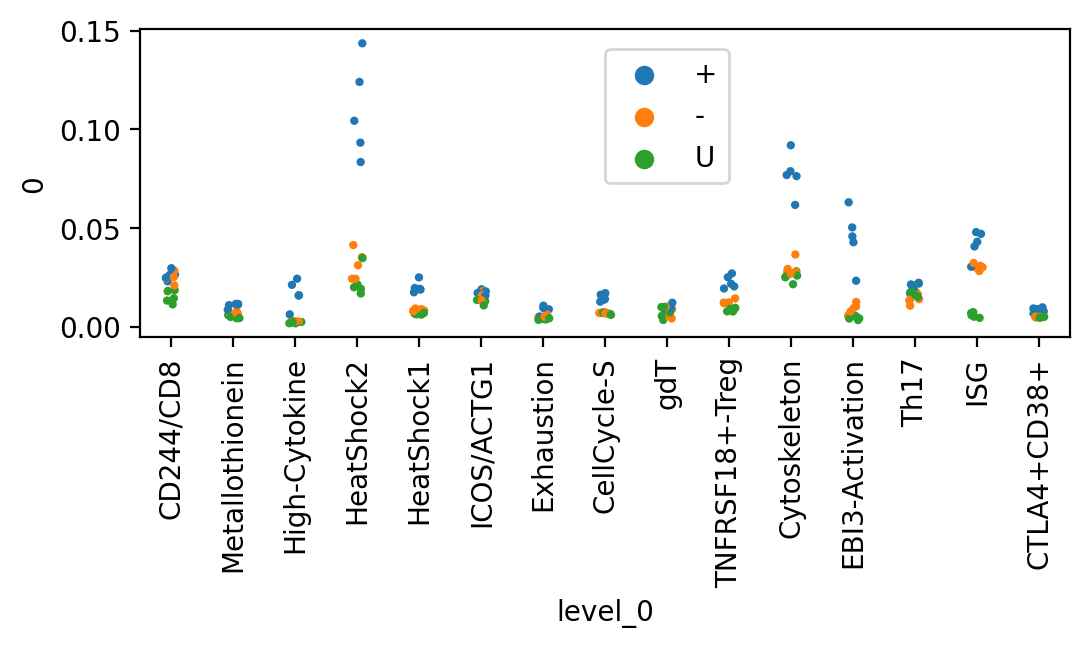

In [192]:
toplot = summary.head(15).index

rf_usage_norm_annot_flat = rf_usage_norm_annot.groupby(['Sort_Status','Biobank_ID']).mean().unstack().unstack().reset_index()
rf_usage_norm_annot_flat = rf_usage_norm_annot_flat.loc[rf_usage_norm_annot_flat['level_0'].isin(toplot),:]

(fig,ax) = plt.subplots(1,1, figsize=(6,2), dpi=200)
sns.stripplot(x='level_0', y=0, hue='Sort_Status', data=rf_usage_norm_annot_flat, order=toplot, s=3)
ax.set_xticklabels([name_dict[x] for x in toplot], rotation=90)
ax.legend(loc=(.5,.5))



/tmp/ipykernel_53349/1476780415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_53349/1476780415.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


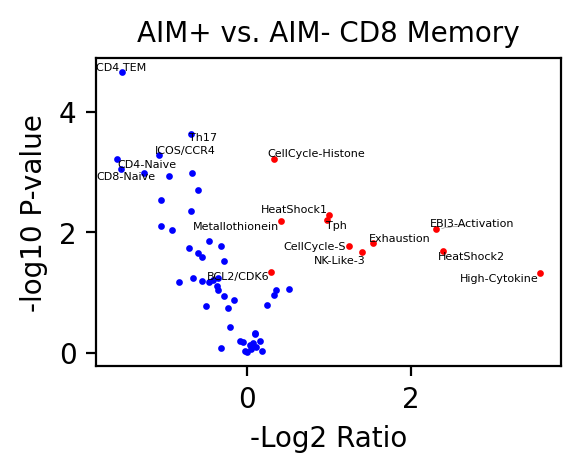

In [193]:
ind = (rf_usage_norm_annot['Sort_Status']!='U') & rf_usage_norm_annot['lineage'].isin(['CD8_CM', 'CD8_EM', 'CD8_TEMRA'])
totest = rf_usage_norm_annot.loc[ind,:]
totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('-', axis=0, level=1)
Ts, Ps = ttest_all_cols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)

summary = pd.concat([Ps, Ts, lograt], axis=1)
summary.columns = ['P', 'T', 'lograt']
summary['logP'] = summary['P'].apply(np.log10)*-1
summary = summary.sort_values(by='T', ascending=False)
summary['renamed'] = [name_dict[x] for x in summary.index]

ind = (summary['T']>0) & (summary['P']<.05)
ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')
ax.set_ylabel('-log10 P-value', fontsize=10)
ax.set_xlabel('-Log2 Ratio', fontsize=10)
ax.set_title('AIM+ vs. AIM- CD8 Memory', fontsize=10)

texts = []
pthresh = .001
for i in summary.index:
    if (summary.at[i, 'P']< pthresh) or ((summary.at[i, 'T']>0) and (summary.at[i, 'P']<.05) ) :
         texts.append(ax.text(summary.at[i, 'lograt'],
                               summary.at[i, 'logP'], name_dict[i],
                               ha='center', va='center', fontsize=4))
        


adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.1))

/tmp/ipykernel_53349/2563975046.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_53349/2563975046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


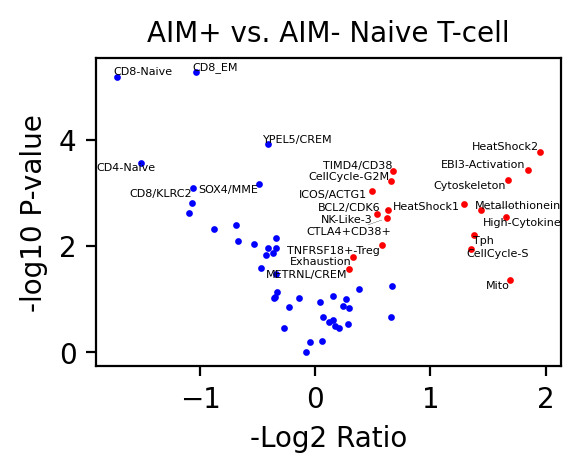

In [194]:
ind = (rf_usage_norm_annot['Sort_Status']!='U') & rf_usage_norm_annot['lineage'].isin(['CD8_Naive', 'CD4_Naive'])
totest = rf_usage_norm_annot.loc[ind,:]
totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('-', axis=0, level=1)
Ts, Ps = ttest_all_cols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)

summary = pd.concat([Ps, Ts, lograt], axis=1)
summary.columns = ['P', 'T', 'lograt']
summary['logP'] = summary['P'].apply(np.log10)*-1
summary = summary.sort_values(by='T', ascending=False)
summary['renamed'] = [name_dict[x] for x in summary.index]

ind = (summary['T']>0) & (summary['P']<.05)
ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')
ax.set_ylabel('-log10 P-value', fontsize=10)
ax.set_xlabel('-Log2 Ratio', fontsize=10)
ax.set_title('AIM+ vs. AIM- Naive T-cell', fontsize=10)

texts = []
pthresh = .001
for i in summary.index:
    if (summary.at[i, 'P']< pthresh) or ((summary.at[i, 'T']>0) and (summary.at[i, 'P']<.05) ) :
         texts.append(ax.text(summary.at[i, 'lograt'],
                               summary.at[i, 'logP'], name_dict[i],
                               ha='center', va='center', fontsize=4))
        


adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.1))

In [89]:
summary

,P,T,lograt,logP,renamed
CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone,0.000602,9.822946,0.326924,3.220242,CellCycle-Histone
HeatShock,0.005115,5.562625,1.004387,2.291189,HeatShock1
AMP-RA:Tph_Single,0.006224,5.267095,0.977960,2.205902,Tph
Metallothionein,0.006514,5.200436,0.407528,2.186139,Metallothionein
EBI3,0.008793,4.777243,2.310819,2.055850,EBI3-Activation
Pan-Cancer:Tex_Single,0.015239,4.068727,1.539340,1.817047,Exhaustion
CellCycle-Sphase_CellCycle_S_DTL/FAM111B,0.016815,3.950208,1.249610,1.774301,CellCycle-S
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5,0.020563,3.715065,2.391195,1.686916,HeatShock2
Pan-Tissue:NK-like_Single,0.021271,3.676401,1.408141,1.672210,NK-Like-3
?BCL2/CDK6_BCL2/CDK6,0.044696,2.887042,0.284066,1.349736,BCL2/CDK6


/tmp/ipykernel_53349/3181211915.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totest['Sort_Status'] = totest['Sort_Status'].astype(str)
/tmp/ipykernel_53349/3181211915.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


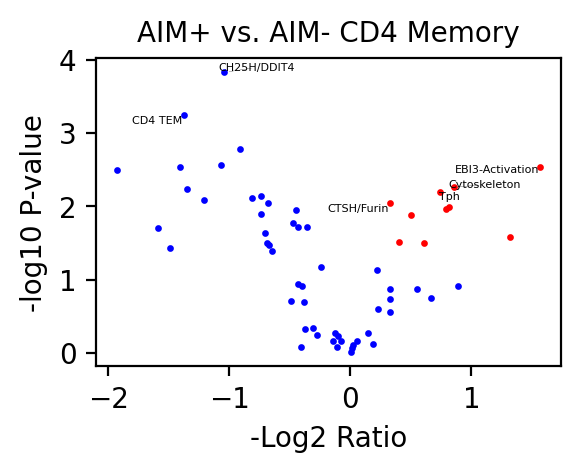

In [92]:
ind = (rf_usage_norm_annot['Sort_Status']!='U') & rf_usage_norm_annot['lineage'].isin(['Treg'])
totest = rf_usage_norm_annot.loc[ind,:]
totest['Sort_Status'] = totest['Sort_Status'].astype(str)
average_usage = totest.groupby(['Biobank_ID', 'Sort_Status']).mean()
average_usage_pos = average_usage.xs('+', axis=0, level=1)
average_usage_neg = average_usage.xs('-', axis=0, level=1)
Ts, Ps = ttest_all_cols(average_usage_pos, average_usage_neg)
lograt = np.log2(average_usage_pos / average_usage_neg).mean(axis=0)
#lograt = (average_usage_pos / average_usage_neg).mean(axis=0).apply(np.log2)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)

summary = pd.concat([Ps, Ts, lograt], axis=1)
summary.columns = ['P', 'T', 'lograt']
summary['logP'] = summary['P'].apply(np.log10)*-1
summary = summary.sort_values(by='T', ascending=False)
summary['renamed'] = [name_dict[x] for x in summary.index]

ind = (summary['T']>0) & (summary['P']<.05)
ax.scatter(summary.loc[ind, 'lograt'], summary.loc[ind, 'logP'], s=2, color='r')
ax.scatter(summary.loc[~ind, 'lograt'], summary.loc[~ind, 'logP'], s=2, color='b')
ax.set_ylabel('-log10 P-value', fontsize=10)
ax.set_xlabel('-Log2 Ratio', fontsize=10)
ax.set_title('AIM+ vs. AIM- CD4 Memory', fontsize=10)

texts = []
pthresh = .001
for i in summary.index:
    if (summary.at[i, 'P']< pthresh) or ((summary.at[i, 'T']>0) and (summary.at[i, 'P']<.01) ) :
         texts.append(ax.text(summary.at[i, 'lograt'],
                               summary.at[i, 'logP'], name_dict[i],
                               ha='center', va='center', fontsize=4))
        


adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.1))

In [93]:
summary

,P,T,lograt,logP,renamed
EBI3,0.002905,6.490685,1.566439,2.536790,EBI3-Activation
Cytoskeleton,0.005493,5.453737,0.855327,2.260198,Cytoskeleton
AMP-RA:Tph_Single,0.006316,5.245732,0.741912,2.199590,Tph
Pan-Cancer:CTSH/FURIN_Single,0.009065,4.735810,0.326536,2.042625,CTSH/Furin
AB_CD278/LGMN/IL21_LAG3/CD38,0.010317,4.562796,0.818243,1.986449,CTLA4+CD38+
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5,0.011045,4.473452,0.791656,1.956822,HeatShock2
HeatShock,0.013155,4.250338,0.503368,1.880925,HeatShock1
CytokineHigh_IL17A/IFNG_TNF/IFNG,0.025985,3.452923,1.321853,1.585277,High-Cytokine
AB_CD86/TIMD4_dnT1/CD38,0.030561,3.277913,0.405259,1.514837,TIMD4/CD38
IL26/CTSH_IL26/RORC/CTSH,0.031542,3.244406,0.604481,1.501109,IL26/CTSH


In [85]:
summary['renamed']

Pan-Tissue:CD244+CD8_Single                                               CD244/CD8
Metallothionein                                                     Metallothionein
CytokineHigh_IL17A/IFNG_TNF/IFNG                                      High-Cytokine
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5                                HeatShock2
HeatShock                                                                HeatShock1
?AB_CD278/ACTG1_AB_CD278/ACTG1                                           ICOS/ACTG1
Pan-Cancer:Tex_Single                                                    Exhaustion
CellCycle-Sphase_CellCycle_S_DTL/FAM111B                                CellCycle-S
KLRC2/GNLY_NK-like_gdT_gdT/Tk                                                   gdT
Pan-Cancer:Treg/TNFRSF18_Single                                      TNFRSF18+-Treg
Cytoskeleton                                                           Cytoskeleton
EBI3                                                                EBI3-Act

In [61]:
rf_usage_norm_annot['lineage'].isin(['CD4_CM', 'CD4_EM', 'CD4_TEMRA'])

3_AAACCTGAGACCGGAT     True
3_AAACCTGAGAGGGCTT    False
3_AAACCTGAGAGTCTGG     True
3_AAACCTGAGCTAGCCC     True
3_AAACCTGAGCTGCCCA     True
                      ...  
2_TTTGTCATCAGGCCCA     True
2_TTTGTCATCATATCGG    False
2_TTTGTCATCATTATCC    False
2_TTTGTCATCGGCTACG    False
2_TTTGTCATCTCCAGGG    False
Name: lineage, Length: 43222, dtype: bool

In [ ]:
rf_usage_norm_annot = pd.concat([rf_usage_norm, query_adata.obs[['Manual_Gating', 'Sort_Status', 'Biobank_ID']]], axis=1)
res = []
res_costim = []
all_averages = []
for ct, ctusage in rf_usage_norm_annot.groupby('Manual_Gating'):
    ctusage_mean = ctusage.groupby(['Sort_Status', 'Biobank_ID']).mean().replace(np.nan, 0)
    ctusage_mean_flat = ctusage_mean.unstack().unstack().reset_index()
    ctusage_mean_flat.columns = ['GEP', 'IDV', 'Condition', 'Usage']
    ctusage_mean_flat['Celltype'] = ct
    all_averages.append(ctusage_mean_flat)
    
    for g in ctusage_mean.columns:
        H, P = ranksums(ctusage_mean.loc['+', g], ctusage_mean.loc[['-', 'U'], g])
        res.append([ct, g, H, P])
        H, P = ranksums(ctusage_mean.loc['U', g], ctusage_mean.loc[['-', '+'], g])
        res_costim.append([ct, g, H, P])        
        
        
res = pd.DataFrame(res, columns=['Celltype', 'gep', 'Z', 'P'])
res_costim = pd.DataFrame(res_costim, columns=['Celltype', 'gep', 'Z', 'P'])

all_averages = pd.concat(all_averages, axis=0)
all_averages = all_averages.loc[~all_averages['Celltype'].isin(['B', 'Myeloid']), :]
res.loc[~res['Celltype'].isin(['B', 'Myeloid']), :]
res_costim.loc[~res_costim['Celltype'].isin(['B', 'Myeloid']), :]

<AxesSubplot: ylabel='Manual_Gating'>

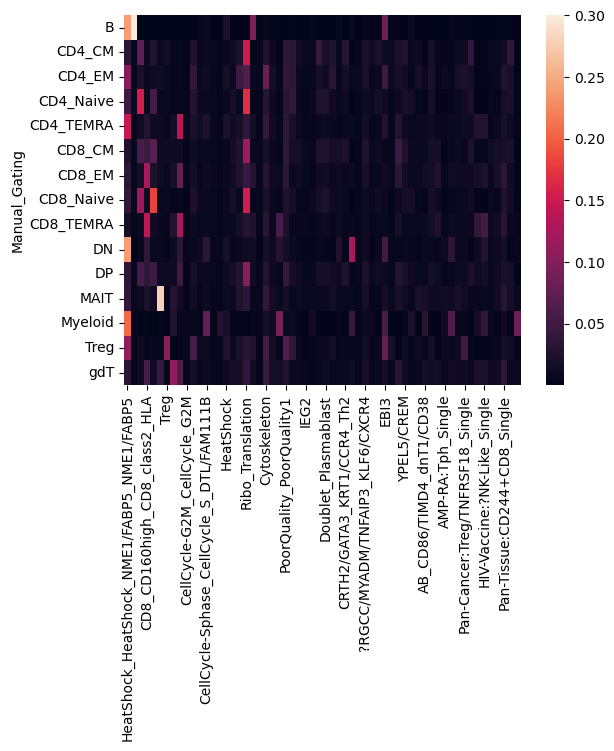

In [11]:
Z = rf_usage_norm.groupby(query_adata.obs['Manual_Gating']).mean()
order = ['HeatShock_HeatShock_NME1/FABP5_NME1/FABP5',
         'Doublet_Bcell_Doublet_Plasmablast',
         'CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Translation/T_Naive', 'CD8_CD160high_CD8_class2_HLA', 'CD8_Naive', 'MAIT', 'Treg', 'gdT', 
        'Cytotoxic_TE']
order += [x for x in Z.columns if x not in order]

sns.heatmap(Z.loc[:,order], vmax=0.3)

In [31]:
from scipy.stats import ranksums

In [108]:
rf_usage_norm_annot = pd.concat([rf_usage_norm, query_adata.obs[['Manual_Gating', 'Sort_Status', 'Biobank_ID']]], axis=1)
res = []
res_costim = []
all_averages = []
for ct, ctusage in rf_usage_norm_annot.groupby('Manual_Gating'):
    ctusage_mean = ctusage.groupby(['Sort_Status', 'Biobank_ID']).mean().replace(np.nan, 0)
    ctusage_mean_flat = ctusage_mean.unstack().unstack().reset_index()
    ctusage_mean_flat.columns = ['GEP', 'IDV', 'Condition', 'Usage']
    ctusage_mean_flat['Celltype'] = ct
    all_averages.append(ctusage_mean_flat)
    
    for g in ctusage_mean.columns:
        H, P = ranksums(ctusage_mean.loc['+', g], ctusage_mean.loc[['-', 'U'], g])
        res.append([ct, g, H, P])
        H, P = ranksums(ctusage_mean.loc['U', g], ctusage_mean.loc[['-', '+'], g])
        res_costim.append([ct, g, H, P])        
        
        
res = pd.DataFrame(res, columns=['Celltype', 'gep', 'Z', 'P'])
res_costim = pd.DataFrame(res_costim, columns=['Celltype', 'gep', 'Z', 'P'])

all_averages = pd.concat(all_averages, axis=0)
all_averages = all_averages.loc[~all_averages['Celltype'].isin(['B', 'Myeloid']), :]
res.loc[~res['Celltype'].isin(['B', 'Myeloid']), :]
res_costim.loc[~res_costim['Celltype'].isin(['B', 'Myeloid']), :]

,Celltype,gep,Z,P
60,CD4_CM,CellCycle-G2M_CellCycle_G2M,-0.979796,0.327187
61,CD4_CM,ISG,-3.061862,0.002200
62,CD4_CM,gdT,-0.612372,0.540291
63,CD4_CM,Metallothionein,-2.816913,0.004849
64,CD4_CM,CellCycle-Sphase_CellCycle_S_DTL/FAM111B,0.857321,0.391267
...,...,...,...,...
895,gdT,HIV-Vaccine:Doublet_Plasmablast_Single,1.102270,0.270344
896,gdT,Pan-Tissue:?METRNL/CREM/LDLRAD4_Single,-0.367423,0.713303
897,gdT,Pan-Tissue:CD244+CD8_Single,-2.449490,0.014306
898,gdT,Pan-Tissue:?CH25H/DDIT4/SOCS3_Single,1.102270,0.270344


In [90]:
res.sort_values(by='P', ascending=True).head(10)

,Celltype,gep,Z,P
795,Treg,Cytoskeleton,3.061862,0.0022
103,CD4_CM,?SOX4/MME_SOX4/MME,-3.061862,0.0022
102,CD4_CM,YPEL5/CREM,-3.061862,0.0022
101,CD4_CM,Effector_Memory_LYAR/GZMK,-3.061862,0.0022
178,CD4_EM,Pan-Tissue:?CH25H/DDIT4/SOCS3_Single,-3.061862,0.0022
180,CD4_Naive,CellCycle-G2M_CellCycle_G2M,3.061862,0.0022
183,CD4_Naive,Metallothionein,3.061862,0.0022
864,gdT,IEG2,-3.061862,0.0022
184,CD4_Naive,CellCycle-Sphase_CellCycle_S_DTL/FAM111B,3.061862,0.0022
94,CD4_CM,CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Tra...,-3.061862,0.0022


In [91]:
res.loc[res['Z']>0, :].sort_values(by='P', ascending=True).head(20)

,Celltype,gep,Z,P
301,CD8_CM,ISG,3.061862,0.0022
367,CD8_EM,HeatShock,3.061862,0.0022
795,Treg,Cytoskeleton,3.061862,0.0022
124,CD4_EM,CellCycle-Sphase_CellCycle_S_DTL/FAM111B,3.061862,0.0022
278,CD4_TEMRA,EBI3,3.061862,0.0022
262,CD4_TEMRA,HeatShock_HeatShock_NME1/FABP5_NME1/FABP5,3.061862,0.0022
243,CD4_TEMRA,Metallothionein,3.061862,0.0022
237,CD4_Naive,Pan-Tissue:CD244+CD8_Single,3.061862,0.0022
229,CD4_Naive,Pan-Cancer:Tex_Single,3.061862,0.0022
226,CD4_Naive,?AB_CD278/ACTG1_AB_CD278/ACTG1,3.061862,0.0022


/tmp/ipykernel_44566/20617627.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90)


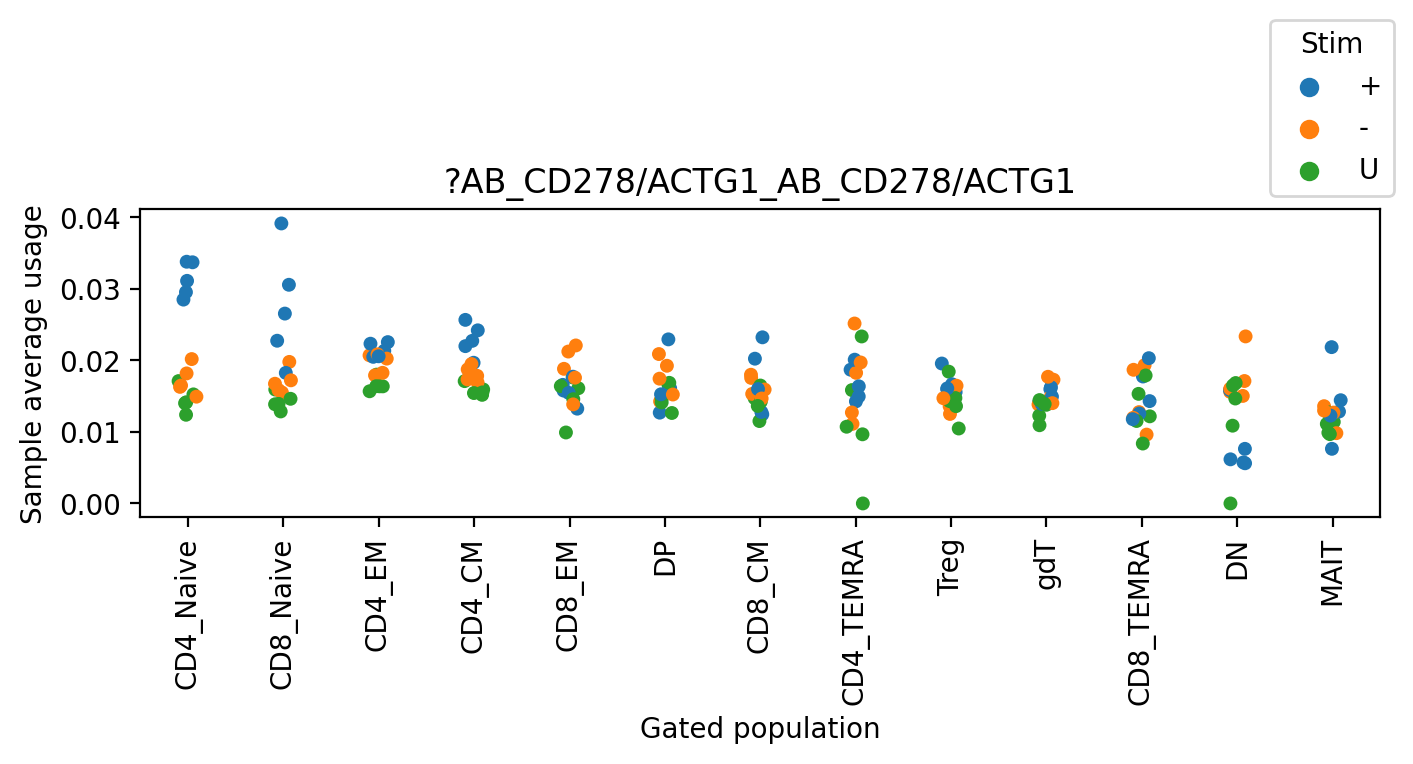

In [94]:
gep = '?AB_CD278/ACTG1_AB_CD278/ACTG1' 
data = all_averages.loc[all_averages['GEP']==gep, :]
order = data.groupby('Celltype')['Usage'].mean().sort_values(ascending=False).index
(fig,ax) = plt.subplots(1,1, figsize=(8,2), dpi=200)
sns.stripplot(x='Celltype', y='Usage', hue='Condition', data=data, ax=ax, order=order)
ax.set_ylabel('Sample average usage')
ax.set_title(gep)
ax.legend(bbox_to_anchor=(.9,1), title='Stim')
ax.set_xticklabels(order, rotation=90)
ax.set_xlabel('Gated population')

pres = res.loc[res['gep']==gep, :]
pres.index = pres['Celltype']

/tmp/ipykernel_44566/3406832750.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90)


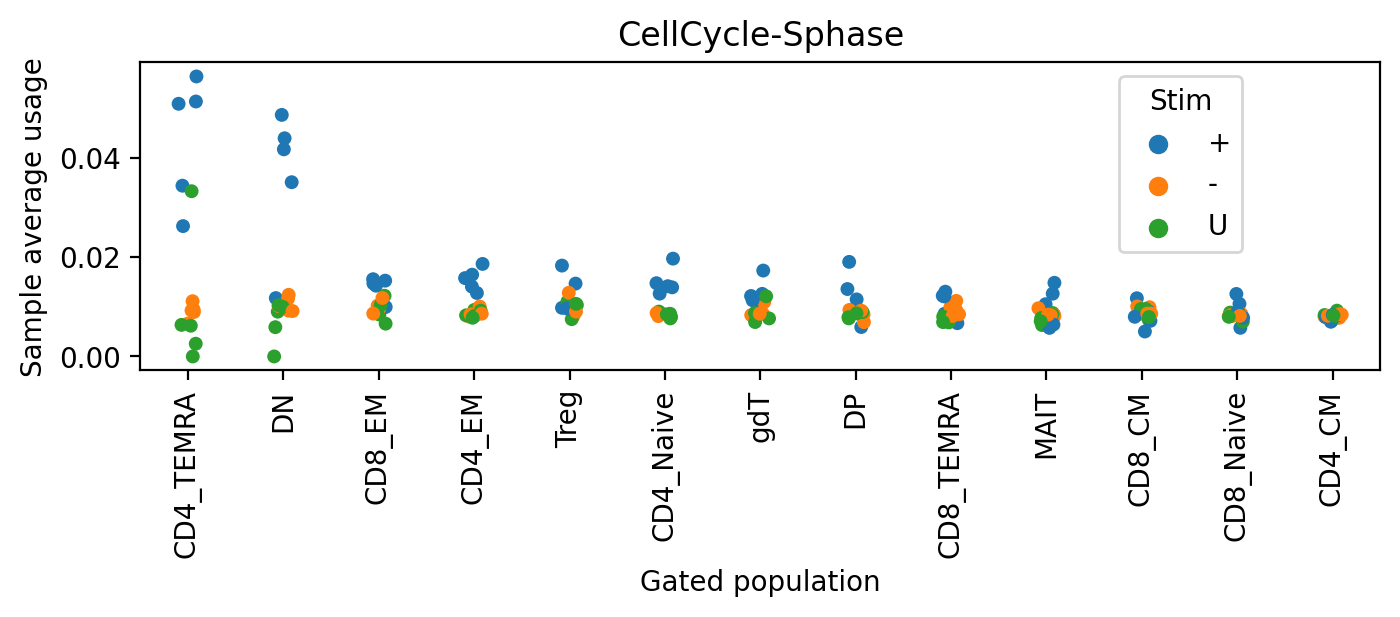

In [96]:
gep = 'CellCycle-Sphase_CellCycle_S_DTL/FAM111B' 
data = all_averages.loc[all_averages['GEP']==gep, :]
order = data.groupby('Celltype')['Usage'].mean().sort_values(ascending=False).index
(fig,ax) = plt.subplots(1,1, figsize=(8,2), dpi=200)
sns.stripplot(x='Celltype', y='Usage', hue='Condition', data=data, ax=ax, order=order)
ax.set_ylabel('Sample average usage')
ax.set_title(gep.split('_')[0])
ax.legend(bbox_to_anchor=(.9,1), title='Stim')
ax.set_xticklabels(order, rotation=90)
ax.set_xlabel('Gated population')

pres = res.loc[res['gep']==gep, :]
pres.index = pres['Celltype']

/tmp/ipykernel_44566/806140850.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90)


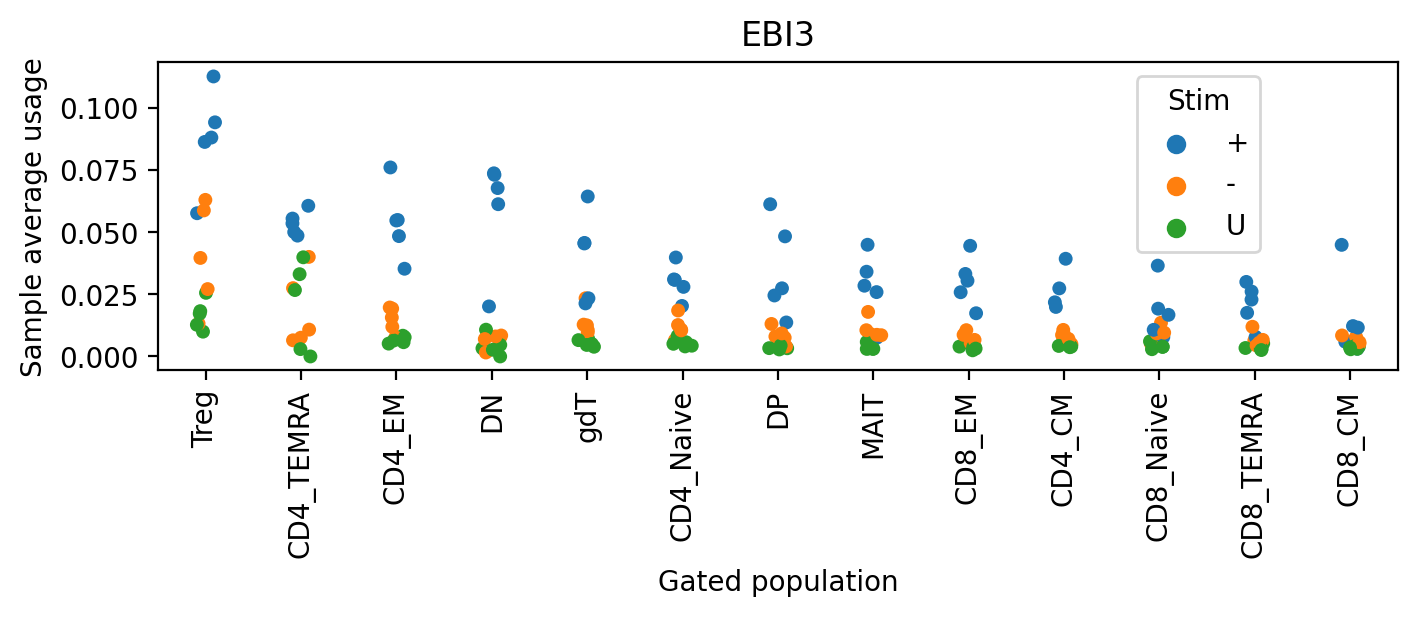

In [98]:
gep = 'EBI3' 
data = all_averages.loc[all_averages['GEP']==gep, :]
order = data.groupby('Celltype')['Usage'].mean().sort_values(ascending=False).index
(fig,ax) = plt.subplots(1,1, figsize=(8,2), dpi=200)
sns.stripplot(x='Celltype', y='Usage', hue='Condition', data=data, ax=ax, order=order)
ax.set_ylabel('Sample average usage')
ax.set_title(gep)
ax.legend(bbox_to_anchor=(.9,1), title='Stim')
ax.set_xticklabels(order, rotation=90)
ax.set_xlabel('Gated population')

pres = res.loc[res['gep']==gep, :]
pres.index = pres['Celltype']

/tmp/ipykernel_44566/844715558.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90)


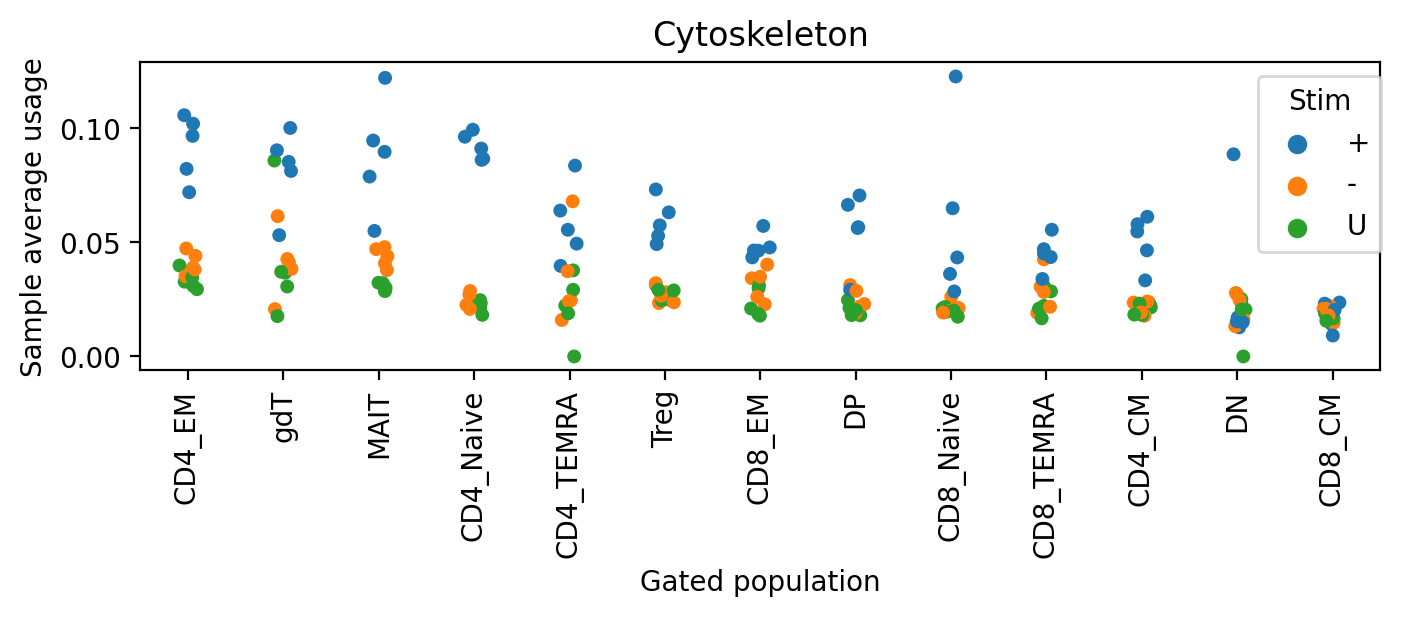

In [103]:
gep = 'Cytoskeleton' 
data = all_averages.loc[all_averages['GEP']==gep, :]
order = data.groupby('Celltype')['Usage'].mean().sort_values(ascending=False).index
(fig,ax) = plt.subplots(1,1, figsize=(8,2), dpi=200)
sns.stripplot(x='Celltype', y='Usage', hue='Condition', data=data, ax=ax, order=order)
ax.set_ylabel('Sample average usage')
ax.set_title(gep)
ax.legend(bbox_to_anchor=(.89,1), title='Stim')
ax.set_xticklabels(order, rotation=90)
ax.set_xlabel('Gated population')

pres = res.loc[res['gep']==gep, :]
pres.index = pres['Celltype']

/tmp/ipykernel_44566/1016044447.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90)


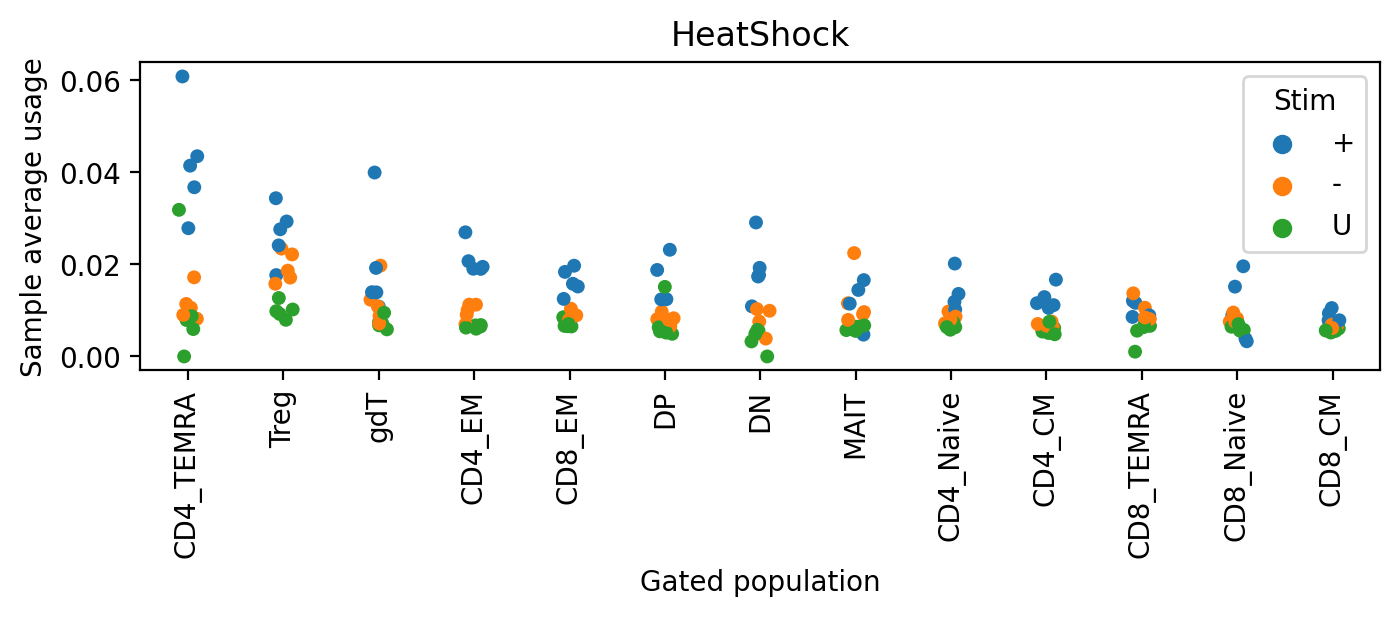

In [104]:
gep = 'HeatShock' 
data = all_averages.loc[all_averages['GEP']==gep, :]
order = data.groupby('Celltype')['Usage'].mean().sort_values(ascending=False).index
(fig,ax) = plt.subplots(1,1, figsize=(8,2), dpi=200)
sns.stripplot(x='Celltype', y='Usage', hue='Condition', data=data, ax=ax, order=order)
ax.set_ylabel('Sample average usage')
ax.set_title(gep)
ax.legend(bbox_to_anchor=(1,1), title='Stim')
ax.set_xticklabels(order, rotation=90)
ax.set_xlabel('Gated population')

pres = res.loc[res['gep']==gep, :]
pres.index = pres['Celltype']

/tmp/ipykernel_44566/2109853767.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90)


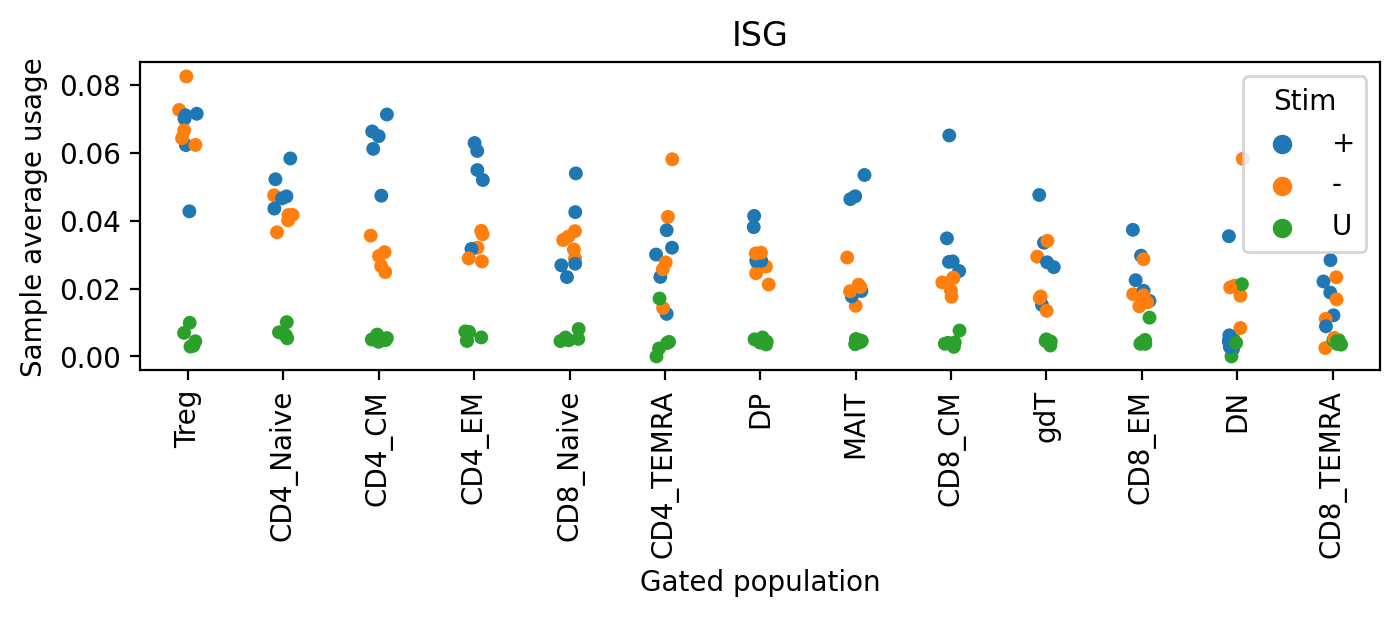

In [106]:
gep = 'ISG' 
data = all_averages.loc[all_averages['GEP']==gep, :]
order = data.groupby('Celltype')['Usage'].mean().sort_values(ascending=False).index
(fig,ax) = plt.subplots(1,1, figsize=(8,2), dpi=200)
sns.stripplot(x='Celltype', y='Usage', hue='Condition', data=data, ax=ax, order=order)
ax.set_ylabel('Sample average usage')
ax.set_title(gep)
ax.legend(bbox_to_anchor=(1,1), title='Stim')
ax.set_xticklabels(order, rotation=90)
ax.set_xlabel('Gated population')


pres = res.loc[res['gep']==gep, :]
pres.index = pres['Celltype']

/tmp/ipykernel_44566/1525888154.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=90)


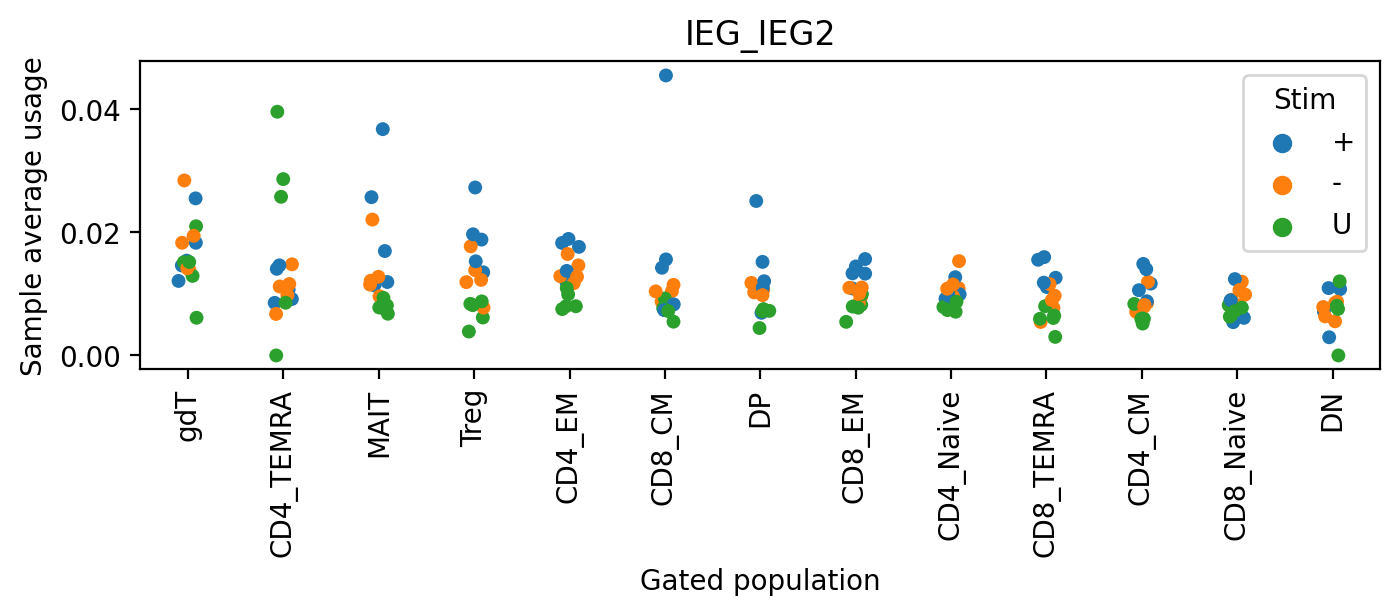

In [117]:
gep = 'IEG_IEG2' 
data = all_averages.loc[all_averages['GEP']==gep, :]
order = data.groupby('Celltype')['Usage'].mean().sort_values(ascending=False).index
(fig,ax) = plt.subplots(1,1, figsize=(8,2), dpi=200)
sns.stripplot(x='Celltype', y='Usage', hue='Condition', data=data, ax=ax, order=order)
ax.set_ylabel('Sample average usage')
ax.set_title(gep)
ax.legend(bbox_to_anchor=(1,1), title='Stim')
ax.set_xticklabels(order, rotation=90)
ax.set_xlabel('Gated population')


pres = res.loc[res['gep']==gep, :]
pres.index = pres['Celltype']

In [114]:
res_costim.sort_values(by='P').head(30)

,Celltype,gep,Z,P
127,CD4_EM,HeatShock,-3.061862,0.0022
382,CD8_EM,HeatShock_HeatShock_NME1/FABP5_NME1/FABP5,-3.061862,0.0022
141,CD4_EM,?BCL2/CDK6_BCL2/CDK6,-3.061862,0.0022
137,CD4_EM,IEG_IEG2,-3.061862,0.0022
136,CD4_EM,MAIT,3.061862,0.0022
214,CD4_Naive,CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Tra...,3.061862,0.0022
802,Treg,HeatShock_HeatShock_NME1/FABP5_NME1/FABP5,-3.061862,0.0022
454,CD8_Naive,CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Tra...,3.061862,0.0022
229,CD4_Naive,Pan-Cancer:Tex_Single,-3.061862,0.0022
361,CD8_EM,ISG,-3.061862,0.0022


In [23]:
ctusage.groupby(query_adata.obs.loc[ctusage.index, ['Sort_Status', 'Biobank_ID']]).mean()

ValueError: Grouper for '<class 'pandas.core.frame.DataFrame'>' not 1-dimensional

In [18]:
ctusage

,CellCycle-G2M_CellCycle_G2M,ISG,gdT,Metallothionein,CellCycle-Sphase_CellCycle_S_DTL/FAM111B,Doublet_RBC,CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone,HeatShock,Mito,?ANXA1/MYADM_?CCR10/LMNA_?IL32/S100A_CD4_Memory_LGALS1/S100A10,...,Pan-Cancer:CTSH/FURIN_Single,Pan-Cancer:Treg/TNFRSF18_Single,TBRU:ICOS/CCR4_Single,HIV-Vaccine:?KLRC2/GNLY_Single,HIV-Vaccine:?NK-Like_Single,HIV-Vaccine:Doublet_Plasmablast_Single,Pan-Tissue:?METRNL/CREM/LDLRAD4_Single,Pan-Tissue:CD244+CD8_Single,Pan-Tissue:?CH25H/DDIT4/SOCS3_Single,Pan-Tissue:NK-like_Single
3_AAAGATGAGAGGTACC,3.830878e-04,8.616138e-05,2.480817e-05,1.367540e-04,1.446426e-02,4.820877e-05,1.041786e-03,1.601785e-03,1.563120e-09,2.242109e-05,...,4.222946e-04,3.995720e-04,1.264613e-05,1.590499e-05,4.048180e-05,0.000260,3.590878e-05,1.902485e-04,4.919286e-05,1.020658e-03
3_ACCTTTAGTGTAATGA,1.414043e-05,9.438384e-06,2.063477e-07,7.121246e-07,3.222157e-06,3.288167e-07,9.957748e-07,7.125690e-06,1.280352e-12,6.359209e-07,...,5.714021e-05,3.316671e-04,8.155402e-09,1.521873e-07,6.410861e-07,0.000001,1.596882e-07,2.259573e-06,2.560949e-07,5.649379e-06
3_ACTGCTCCAACGCACC,3.277263e-03,3.670183e-03,3.058715e-04,5.823454e-04,7.021951e-03,5.894002e-04,2.512479e-03,3.435472e-02,1.231988e-09,1.622991e-03,...,1.524929e-03,1.507840e-03,1.698831e-04,1.033259e-04,2.628860e-04,0.002158,8.287060e-04,2.127200e-03,3.241357e-04,1.685621e-03
3_AGAGCGAAGCCTCGTG,9.104401e-10,1.270513e-10,1.004466e-09,6.989653e-09,5.638214e-09,1.277554e-08,2.368753e-09,4.666047e-11,5.336048e-14,1.138480e-08,...,1.204884e-09,1.243023e-07,3.188987e-09,1.684222e-09,6.607401e-08,0.000002,6.348534e-10,2.410914e-10,1.470439e-08,4.362100e-07
3_AGAGCTTGTCTAGAGG,3.382738e-04,4.637917e-04,3.553408e-05,4.558749e-03,1.146633e-03,3.905025e-05,2.670520e-04,7.002615e-03,1.854949e-11,1.215141e-04,...,4.246027e-04,1.079057e-03,1.078554e-05,6.073420e-06,1.070044e-04,0.000199,1.585977e-05,1.402587e-04,1.006626e-05,1.861975e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4_TGCTACCCACCTATCC,3.514746e-03,4.754730e-04,2.330045e-04,4.925166e-03,1.061419e-02,4.767339e-04,2.381967e-03,9.761201e-03,7.731225e-09,1.951662e-04,...,2.396351e-03,1.079396e-03,7.379046e-05,5.122491e-05,9.597731e-05,0.000704,1.201122e-03,1.346463e-03,2.246583e-04,1.066408e-03
4_TGGCCAGGTCTTGATG,3.052875e-03,2.357927e-04,7.343159e-05,7.272889e-04,2.628233e-02,1.845728e-04,1.812652e-03,3.254269e-02,2.858824e-10,3.280613e-04,...,1.125184e-03,3.816568e-04,1.490374e-05,2.467449e-05,1.107773e-04,0.000484,6.294509e-04,7.510144e-04,1.243468e-04,8.446228e-04
4_TGTGTTTGTCAGAATA,6.784318e-05,2.269013e-06,4.159017e-06,2.466362e-05,2.319316e-04,1.083523e-05,1.059197e-04,2.908612e-04,5.920163e-11,5.758666e-06,...,1.769550e-05,3.380995e-04,2.709595e-06,1.433079e-06,1.553426e-06,0.000090,6.054937e-06,8.614868e-05,9.175589e-06,1.007268e-04
4_TTCGGTCTCATCGCTC,3.690695e-04,1.493598e-04,7.313380e-05,1.238963e-02,8.460876e-03,3.182410e-04,4.357425e-04,2.288070e-02,2.233300e-09,7.266852e-05,...,5.850417e-04,5.358350e-04,7.119653e-06,3.164006e-05,8.023786e-05,0.000469,6.904454e-04,2.335820e-03,4.644784e-05,1.965719e-03


In [21]:
query_adata.obs.columns

Index(['barcode', 'BRI', 'Run', 'Well', 'Batch', 'Biobank_ID', 'Sort_Status',
       'HTO_Status', 'Demuxlet_Assignment', 'Total_RNA_Count',
       'Total_ADT_Count', 'Total_HTO_Count', 'frac_ADT', 'A_cdr3', 'B_cdr3',
       'DEMUX_RD.UNIQ', 'DEMUX_N.SNP', 'DEMUX_BEST', 'DEMUX_SNG.1ST',
       'DEMUX_SNG.LLK1', 'DEMUX_DBL.1ST', 'DEMUX_DBL.2ND', 'DEMUX_LLK12',
       'DEMUX_PRB.DBL', 'DEMUX_PRB.SNG1', 'batch_name', 'B_is_cell',
       'B_high_confidence', 'B_full_length', 'B_productive', 'B_length',
       'B_v_gene', 'B_d_gene', 'B_j_gene', 'B_c_gene', 'B_cdr1', 'B_cdr2',
       'B_cdr3_nt', 'B_reads', 'B_umis', 'B_raw_clonotype_id',
       'B_raw_consensus_id', 'B_Num_Hits_In_Barcode',
       'B_Next_Highest_ReadCount', 'B_Num_Productive_In_Barcode',
       'B_Has_Unproductive', 'A_is_cell', 'A_high_confidence', 'A_full_length',
       'A_productive', 'A_length', 'A_v_gene', 'A_d_gene', 'A_j_gene',
       'A_c_gene', 'A_cdr1', 'A_cdr2', 'A_cdr3_nt', 'A_reads', 'A_umis',
       'A_raw_

In [130]:
Z.loc['CD3_NAi', :].sort_values(ascending=False)

CD8_CD160high_CD8_class2_HLA                                      0.141742
Cytotoxic_TE                                                      0.124082
KLRC2/GNLY_NK-like_gdT_gdT/Tk                                     0.055458
HIV-Vaccine:?NK-Like_Single                                       0.052841
HIV-Vaccine:?KLRC2/GNLY_Single                                    0.039501
Pan-Tissue:CD244+CD8_Single                                       0.032551
Cytoskeleton                                                      0.030916
Ribo_Translation                                                  0.028734
gdT                                                               0.028153
Doublet_DC_HLA                                                    0.025786
CD8A/GNLY_Memory                                                  0.025267
PoorQuality_PoorQuality1                                          0.023471
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5                         0.018559
Effector_Memory_LYAR/GZMK

In [ ]:
lineages = ['CellCycle-G2M_CellCycle_G2M', 'ISG', 'gdT', 'Metallothionein',
       'CellCycle-Sphase_CellCycle_S_DTL/FAM111B', 'Doublet_RBC',
       'CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone', 'HeatShock',
       'Mito',
       '?ANXA1/MYADM_?CCR10/LMNA_?IL32/S100A_CD4_Memory_LGALS1/S100A10',
       'Ribo_Translation', 'Cytotoxic_TE', 'Treg', 'Doublet_DC_HLA',
       'Doublet_Platelet', 'Cytoskeleton', 'MAIT', 'IEG_IEG2',
       'KLRC2/GNLY_NK-like_gdT_gdT/Tk', 'CD8_CD160high_CD8_class2_HLA',
       'PoorQuality_PoorQuality1', '?BCL2/CDK6_BCL2/CDK6',
       'HeatShock_HeatShock_NME1/FABP5_NME1/FABP5', 'IEG_IEG1_KLF6/CXCR4',
       'IEG2', '?Doublet_Myeloid_?GutMyeloid2_MMP8_Doublet_Myeloid',
       'CD8_Naive', '?AB_CD278/ACTG1_CD4_CM-1_LIMS1/PASK',
       'Doublet_Plasmablast', 'CD4_CM-2_PTPN13/TNFRSF4_Th17',
       'AMP-RA_CD38_dnT_dnT/IL10+CD38+', 'CRTH2/GATA3_KRT1/CCR4_Th2',
       'CytokineHigh_IL17A/IFNG_TNF/IFNG', 'Th2',
       'CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Translation/T_Naive',
       '?RGCC/MYADM/TNFAIP3_KLF6/CXCR4',
       '?PlasmaDoublet/FCN3/FCN2/OIT3_CRHBP/CLEC4G', 'Tfh', 'EBI3',
       'Doublet_Bcell_Doublet_Plasmablast', 'AB_CD278/LGMN/IL21_LAG3/CD38',
       'Effector_Memory_LYAR/GZMK', 'YPEL5/CREM', '?SOX4/MME_SOX4/MME',
       'IL26/CTSH_IL26/RORC/CTSH', 'AB_CD86/TIMD4_dnT1/CD38',
       '?AB_CD278/ACTG1_AB_CD278/ACTG1', 'CD8A/GNLY_Memory',
       'AMP-RA:Tph_Single', 'Pan-Cancer:Tex_Single',
       'Pan-Cancer:CTSH/FURIN_Single', 'Pan-Cancer:Treg/TNFRSF18_Single',
       'TBRU:ICOS/CCR4_Single', 'HIV-Vaccine:?KLRC2/GNLY_Single',
       'HIV-Vaccine:?NK-Like_Single', 'HIV-Vaccine:Doublet_Plasmablast_Single',
       'Pan-Tissue:?METRNL/CREM/LDLRAD4_Single', 'Pan-Tissue:CD244+CD8_Single',
       'Pan-Tissue:?CH25H/DDIT4/SOCS3_Single', 'Pan-Tissue:NK-like_Single']

In [55]:
rf_usage_norm = rf_usage.div(rf_usage.sum(axis=1), axis=0)

In [62]:
(rf_usage_norm>.1).sum(axis=0).sort_values(ascending=True)

?AB_CD278/ACTG1_AB_CD278/ACTG1                                        5
CellCycle-G2M_CellCycle_G2M                                           6
Doublet_RBC                                                          14
AMP-RA:Tph_Single                                                    21
IEG2                                                                 25
CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone               29
Doublet_Platelet                                                     37
Doublet_Plasmablast                                                  42
HIV-Vaccine:Doublet_Plasmablast_Single                               47
IEG_IEG1_KLF6/CXCR4                                                  47
Pan-Tissue:NK-like_Single                                            48
?PlasmaDoublet/FCN3/FCN2/OIT3_CRHBP/CLEC4G                           55
AB_CD86/TIMD4_dnT1/CD38                                              56
YPEL5/CREM                                                      

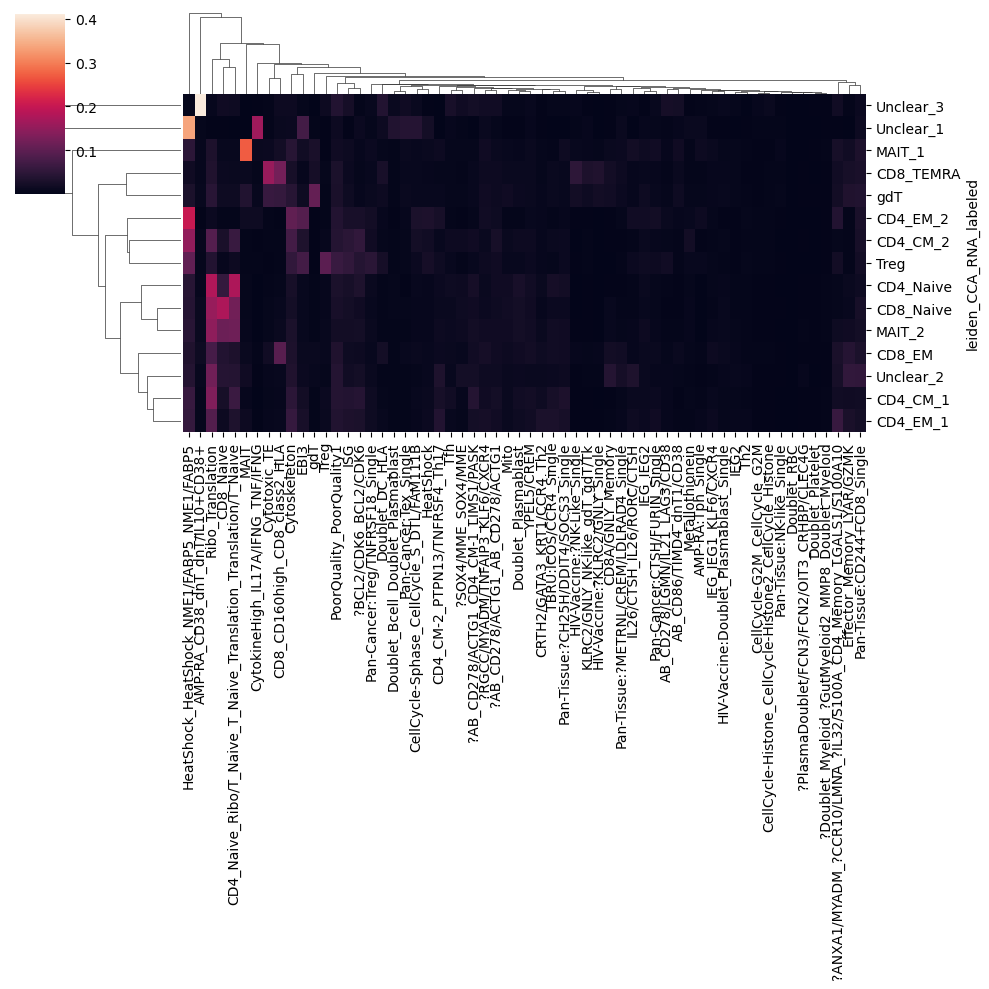

In [64]:
sns.clustermap(rf_usage_norm.groupby(query_adata.obs['leiden_CCA_RNA_labeled']).mean(), xticklabels=True, yticklabels=True)

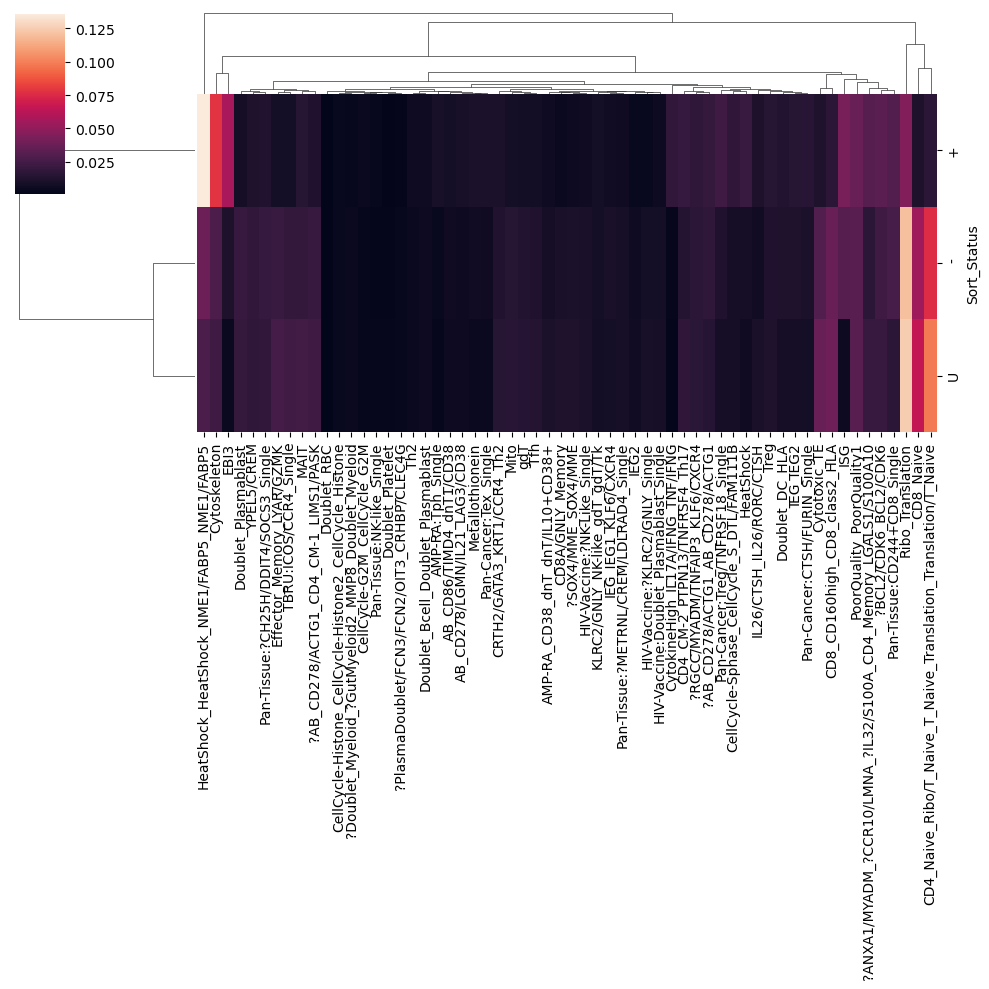

In [65]:
sns.clustermap(rf_usage_norm.groupby(query_adata.obs['Sort_Status']).mean(), xticklabels=True)

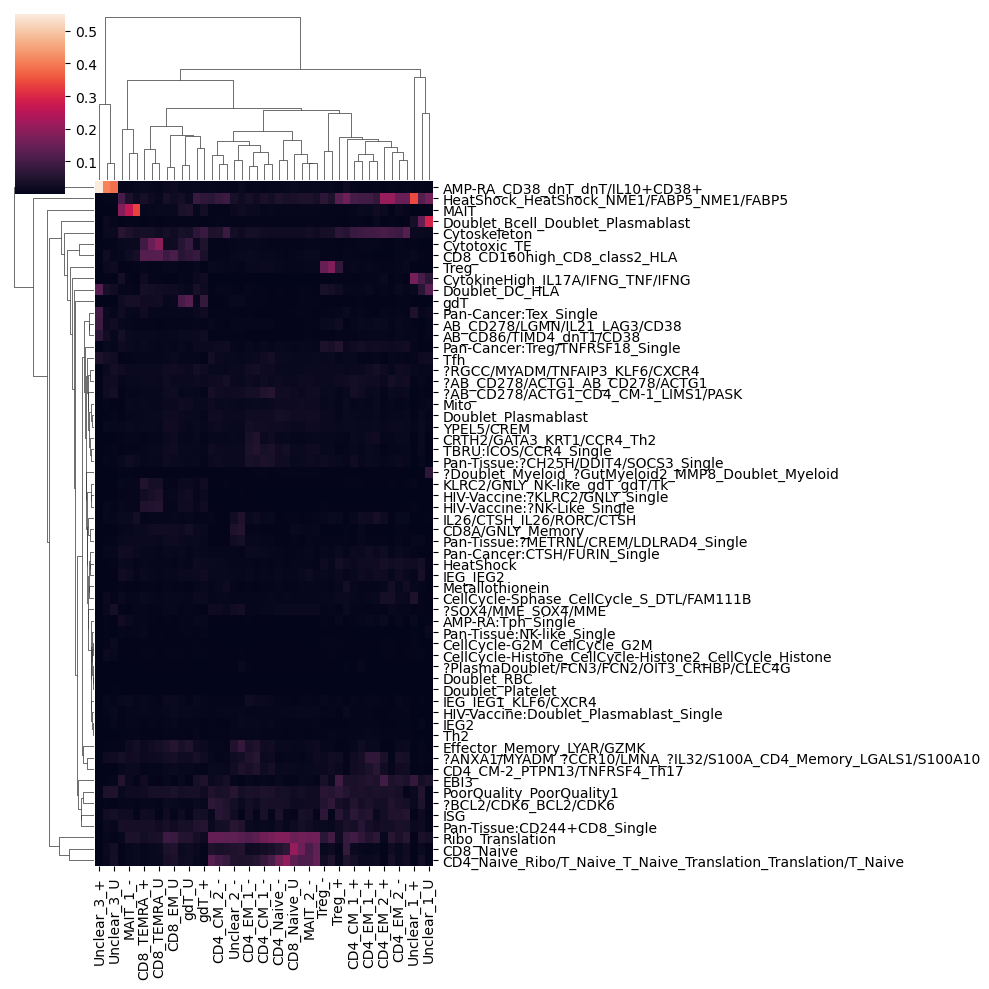

In [75]:
lab = query_adata.obs['leiden_CCA_RNA_labeled'].astype(str) + '_' + query_adata.obs['Sort_Status'].astype(str)
sns.clustermap(rf_usage_norm.groupby(lab).mean().T, yticklabels=True)

In [71]:
query_adata.obs['leiden_CCA_RNA_labeled'].astype(str) + '_' + query_adata.obs['Sort_Status'].astype(str)

3_AAACCTGAGAGGGCTT    CD4_Naive_U
3_AAACCTGAGAGTCTGG     CD4_EM_2_+
3_AAACCTGAGCTAGCCC     CD4_CM_1_U
3_AAACCTGAGCTGCCCA     CD4_EM_1_+
3_AAACCTGAGGCTCATT     CD4_EM_2_+
                         ...     
2_TTTGTCAGTTCCACTC         Treg_+
2_TTTGTCATCAGGCCCA     CD4_CM_1_U
2_TTTGTCATCATATCGG    CD8_TEMRA_+
2_TTTGTCATCATTATCC    CD8_Naive_-
2_TTTGTCATCTCCAGGG          gdT_-
Length: 40661, dtype: object

Text(0, 0.5, 'Score')

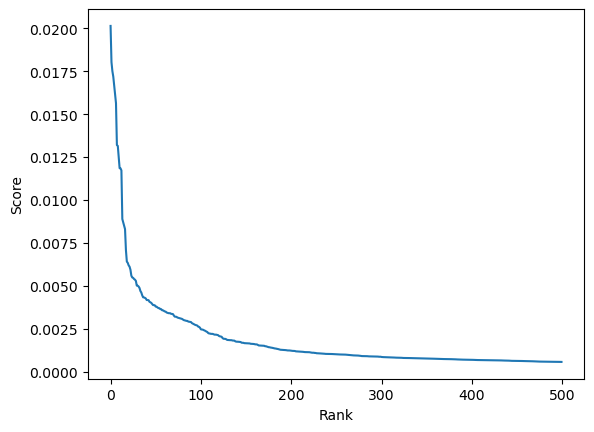

In [148]:
z = pd.read_csv('/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/XTissueImmuneAtlas/T_Script_AllT_XTissue_20220824/T_Script_AllT_XTissue_20220824.gene_spectra_score.k_49.dt_0_2.labeled.txt', sep='\t', index_col=0)['IEG'].sort_values(ascending=False)
plt.plot(np.arange(500), z.values[:500])
plt.xlabel('Rank')
plt.ylabel('Score')

In [147]:
z.to_csv('ieg.tsv', sep='\t')

In [14]:
query_adata

AnnData object with n_obs × n_vars = 40661 × 36738
    obs: 'barcode', 'BRI', 'Run', 'Well', 'Batch', 'Biobank_ID', 'Sort_Status', 'HTO_Status', 'Demuxlet_Assignment', 'Total_RNA_Count', 'Total_ADT_Count', 'Total_HTO_Count', 'frac_ADT', 'A_cdr3', 'B_cdr3', 'DEMUX_RD.UNIQ', 'DEMUX_N.SNP', 'DEMUX_BEST', 'DEMUX_SNG.1ST', 'DEMUX_SNG.LLK1', 'DEMUX_DBL.1ST', 'DEMUX_DBL.2ND', 'DEMUX_LLK12', 'DEMUX_PRB.DBL', 'DEMUX_PRB.SNG1', 'batch_name', 'B_is_cell', 'B_high_confidence', 'B_full_length', 'B_productive', 'B_length', 'B_v_gene', 'B_d_gene', 'B_j_gene', 'B_c_gene', 'B_cdr1', 'B_cdr2', 'B_cdr3_nt', 'B_reads', 'B_umis', 'B_raw_clonotype_id', 'B_raw_consensus_id', 'B_Num_Hits_In_Barcode', 'B_Next_Highest_ReadCount', 'B_Num_Productive_In_Barcode', 'B_Has_Unproductive', 'A_is_cell', 'A_high_confidence', 'A_full_length', 'A_productive', 'A_length', 'A_v_gene', 'A_d_gene', 'A_j_gene', 'A_c_gene', 'A_cdr1', 'A_cdr2', 'A_cdr3_nt', 'A_reads', 'A_umis', 'A_raw_clonotype_id', 'A_raw_consensus_id', 'A_Num_H

,gene_sybmol,gene_name,feature_type
gene_sybmol,,,
ENSG00000000003,ENSG00000000003,TSPAN6,Gene Expression
ENSG00000000005,ENSG00000000005,TNMD,Gene Expression
ENSG00000000419,ENSG00000000419,DPM1,Gene Expression
ENSG00000000457,ENSG00000000457,SCYL3,Gene Expression
ENSG00000000460,ENSG00000000460,C1orf112,Gene Expression
...,...,...,...
TCRVa7.2_prot,TCRVa7.2_prot,TCRVa7.2_prot,Antibody Capture
TCRVd2_prot,TCRVd2_prot,TCRVd2_prot,Antibody Capture
TCRa_or_b_prot,TCRa_or_b_prot,TCRa_or_b_prot,Antibody Capture
